<table align="center" width=150%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=8px>
                    <b> Assignment 3: Emotion Classification Based on Social Media Data <br>
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

This set of implementation explores the performance results of the five models under consideration - SVC, BiLSTM, BERT, RoBERTa and DistilBERT models where the text preprocessing steps additionally included 1. removal of stop words and 2. changing word to base/root form - lemmatization. This is not the final implementation file. Refer to nlp_a3_final_implementation.ipynb file in the repository for the proposed solution and results.

In [ ]:
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2


In [ ]:
!pip install text_hammer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.3
    Uninstalling beautifulsoup4-4.12.3:
      Successfully uninstalled beautifulsoup4-4.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.38 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

####Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/NLP/

/content/drive/MyDrive/NLP


####Importing the required libraries

In [ ]:
import pandas as pd
import numpy as np
import random

import text_hammer as th
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn import svm
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import TFBertModel, TFDistilBertModel, TFRobertaModel
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score

from transformers import BertTokenizerFast, RobertaTokenizerFast, DistilBertTokenizerFast
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, Input

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

###Loading the Hugging face emotion datasets - train, test and validation

In [ ]:
train_df = pd.read_parquet("train.parquet")
validation_df = pd.read_parquet("validation.parquet")
test_df = pd.read_parquet("test.parquet")

In [ ]:
print("Shape of Train dataset:", train_df.shape)
print("Shape of Validation dataset:", validation_df.shape)
print("Shape of Test dataset:", test_df.shape)

Shape of Train dataset: (3257, 2)
Shape of Validation dataset: (374, 2)
Shape of Test dataset: (1421, 2)


In [ ]:
train_df.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [ ]:
validation_df.head()

,text,label
0,"@user @user Oh, hidden revenge and anger...I r...",0
1,if not then #teamchristine bc all tana has don...,0
2,Hey @user #Fields in #skibbereen give your onl...,0
3,Why have #Emmerdale had to rob #robron of havi...,0
4,@user I would like to hear a podcast of you go...,0


In [ ]:
test_df.head()

,text,label
0,#Deppression is real. Partners w/ #depressed p...,3
1,@user Interesting choice of words... Are you c...,0
2,My visit to hospital for care triggered #traum...,3
3,@user Welcome to #MPSVT! We are delighted to h...,1
4,What makes you feel #joyful?,1


#####Checking the null values and data types of the attributes in the given dataset

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3257 non-null   object
 1   label   3257 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


In [ ]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    374 non-null    object
 1   label   374 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1421 non-null   object
 1   label   1421 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.3+ KB


####Converting label into categorical type for visualization

In [ ]:
train_df["label"] = train_df["label"].astype(object)
validation_df["label"] = validation_df["label"].astype(object)
test_df["label"] = test_df["label"].astype(object)

In [ ]:
train_df["label"].value_counts()

label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64

In [ ]:
validation_df["label"].value_counts()

label
0    160
1     97
3     89
2     28
Name: count, dtype: int64

In [ ]:
test_df["label"].value_counts()

label
0    558
3    382
1    358
2    123
Name: count, dtype: int64

####Distribution of Target Labels in train, validation and test datasets

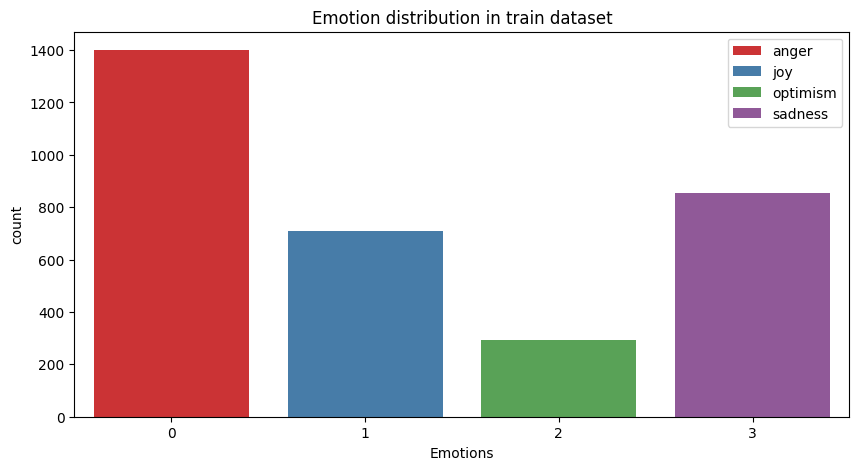

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=train_df["label"], palette="Set1")
plt.legend({'anger':0,'joy':1, 'optimism':2, 'sadness':3})
plt.title("Emotion distribution in train dataset")
plt.xlabel("Emotions")
plt.show()

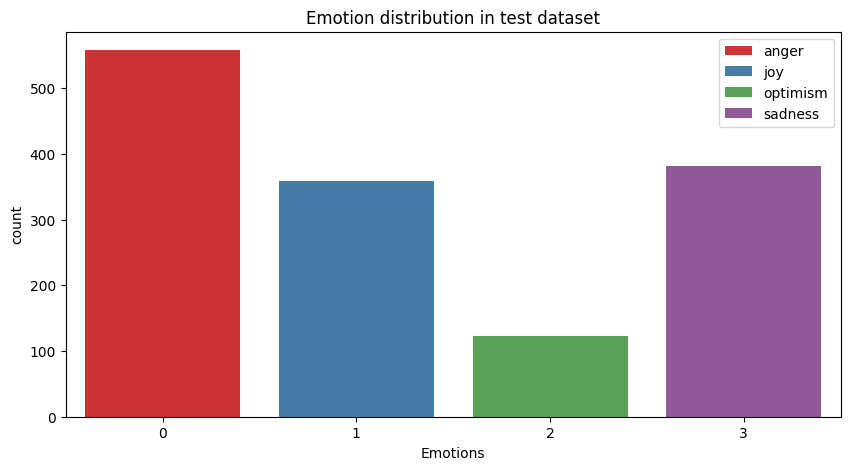

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=test_df["label"], palette="Set1")
plt.legend({'anger':0,'joy':1, 'optimism':2, 'sadness':3})
plt.title("Emotion distribution in test dataset")
plt.xlabel("Emotions")
plt.show()

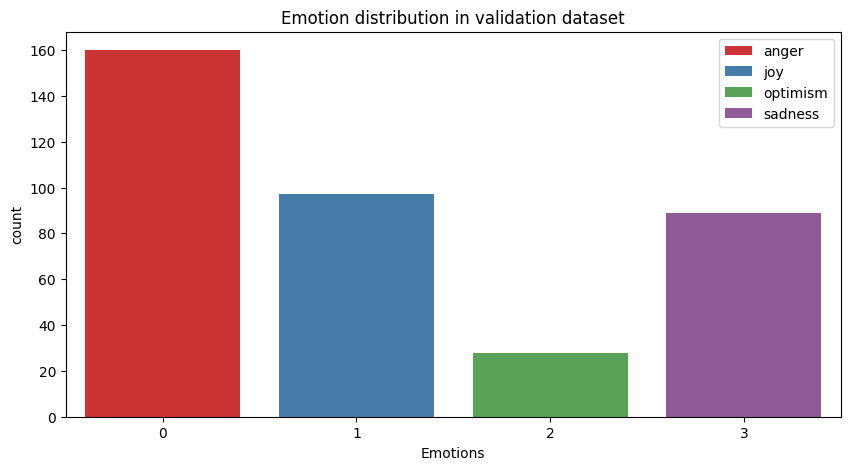

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=validation_df["label"], palette="Set1")
plt.legend({'anger':0,'joy':1, 'optimism':2, 'sadness':3})
plt.title("Emotion distribution in validation dataset")
plt.xlabel("Emotions")
plt.show()

#####Imbalance in the dataset: It could be seen that majority of the tweets in the given dataset (train, test and validation) is of emotion type - Anger and least for optimism. Joy and Sadness tweets are almost equal. This causes a clear imbalance in the class labels of the target variable, which could potentially lead to overfitting models and disproportionate weightage given to Anger emotion compared to the remaining three.

#####Analysing the maximum word length of the tweets before basic text cleaning

In [ ]:
train_df['word_len'] = train_df['text'].apply(lambda x:len(x.split()))
validation_df['word_len'] = validation_df['text'].apply(lambda x:len(x.split()))
test_df['word_len'] = test_df['text'].apply(lambda x:len(x.split()))

In [ ]:
print("Maximum tweet length in train dataset:", train_df['word_len'].max())
print("Maximum tweet length in test dataset:", test_df['word_len'].max())
print("Maximum tweet length in validation dataset:", validation_df['word_len'].max())

Maximum tweet length in train dataset: 33
Maximum tweet length in test dataset: 36
Maximum tweet length in validation dataset: 32


####Text preprocessing/cleaning
1.   Changing to lower case
2.   Exapnding words like you're to you are, i'm to I am
3.   Removing emails
4.   Removing html tags
5.   Removing special characters like @, #, % etc
6.   Removing accented characters like u^, `a etc
7. Lemmatization - changing to root word form
8. Removal of stop words such as a, the etc











In [ ]:
def text_cleaning(df):
  df["text"] = df["text"].progress_apply(lambda x:str(x).lower())
  df["text"] = df["text"].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
  df["text"] = df["text"].progress_apply(lambda x: th.remove_emails(x))
  df["text"] = df["text"].progress_apply(lambda x: th.remove_html_tags(x))
  df["text"] = df["text"].progress_apply(lambda x: th.remove_special_chars(x))
  df["text"] = df["text"].progress_apply(lambda x: th.remove_accented_chars(x))
  df["text"] = df["text"].progress_apply(lambda x: th.make_base(x))
  df["text"] = df["text"].progress_apply(lambda x: th.remove_stopwords(x))
  return(df)

In [ ]:
train_df_cleaned = text_cleaning(train_df.copy())
test_df_cleaned = text_cleaning(test_df.copy())
validation_df_cleaned = text_cleaning(validation_df.copy())

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/3257 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/1421 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

In [ ]:
original_train = train_df["text"][:5]
cleaned_train = train_df_cleaned["text"][:5]
pd.DataFrame(dict(original = original_train, cleaned=cleaned_train)).reset_index(drop=True)

,original,cleaned
0,“Worry is a down payment on a problem you may ...,worry payment problem joyce meyer motivation l...
1,My roommate: it's okay that we can't spell bec...,roommate okay spell autocorrect terrible first...
2,No but that's so cute. Atsu was probably shy a...,cute atsu probably shy photo cherry help uwu
3,Rooneys fucking untouchable isn't he? Been fuc...,rooney fucking untouchable fuck dreadful depay...
4,it's pretty depressing when u hit pan on ur fa...,pretty depressing hit pan favourite highlighter


In [ ]:
original_test = test_df["text"][:5]
cleaned_test = test_df_cleaned["text"][:5]
pd.DataFrame(dict(original = original_test, cleaned=cleaned_test)).reset_index(drop=True)

,original,cleaned
0,#Deppression is real. Partners w/ #depressed p...,deppression real partner w depress people trul...
1,@user Interesting choice of words... Are you c...,user interesting choice word confirm governmen...
2,My visit to hospital for care triggered #traum...,visit hospital care trigger trauma accident 20...
3,@user Welcome to #MPSVT! We are delighted to h...,user welcome mpsvt delighted grateful mpsvt re...
4,What makes you feel #joyful?,feel joyful


In [ ]:
original_val = validation_df["text"][:5]
cleaned_val = validation_df_cleaned["text"][:5]
pd.DataFrame(dict(original = original_val, cleaned=cleaned_val)).reset_index(drop=True)

,original,cleaned
0,"@user @user Oh, hidden revenge and anger...I r...",user user oh hidden revenge angeri rememberthe...
1,if not then #teamchristine bc all tana has don...,teamchristine bc tana provoke tweet shady shit...
2,Hey @user #Fields in #skibbereen give your onl...,hey user field skibbereen online delivery serv...
3,Why have #Emmerdale had to rob #robron of havi...,emmerdale rob robron child vile womancheating ...
4,@user I would like to hear a podcast of you go...,user I like hear podcast refute entire article...


It can be clearly seen that text cleaning has modified the given text removing stop words, special charatcers, symbols etc.

#####Analysing the word length of each tweet after basic text cleaning

In [ ]:
train_df_cleaned['word_len'] = train_df_cleaned['text'].apply(lambda x:len(x.split()))
validation_df_cleaned['word_len'] = validation_df_cleaned['text'].apply(lambda x:len(x.split()))
test_df_cleaned['word_len'] = test_df_cleaned['text'].apply(lambda x:len(x.split()))

In [ ]:
train_df_cleaned.head()

,text,label,word_len
0,worry payment problem joyce meyer motivation l...,2,8
1,roommate okay spell autocorrect terrible first...,0,6
2,cute atsu probably shy photo cherry help uwu,1,8
3,rooney fucking untouchable fuck dreadful depay...,0,8
4,pretty depressing hit pan favourite highlighter,3,6


In [ ]:
print("Maximum tweet length in cleaned train dataset:", train_df_cleaned['word_len'].max())
print("Maximum tweet length in cleaned test dataset:", test_df_cleaned['word_len'].max())
print("Maximum tweet length in cleaned validation dataset:", validation_df_cleaned['word_len'].max())

Maximum tweet length in cleaned train dataset: 21
Maximum tweet length in cleaned test dataset: 23
Maximum tweet length in cleaned validation dataset: 22


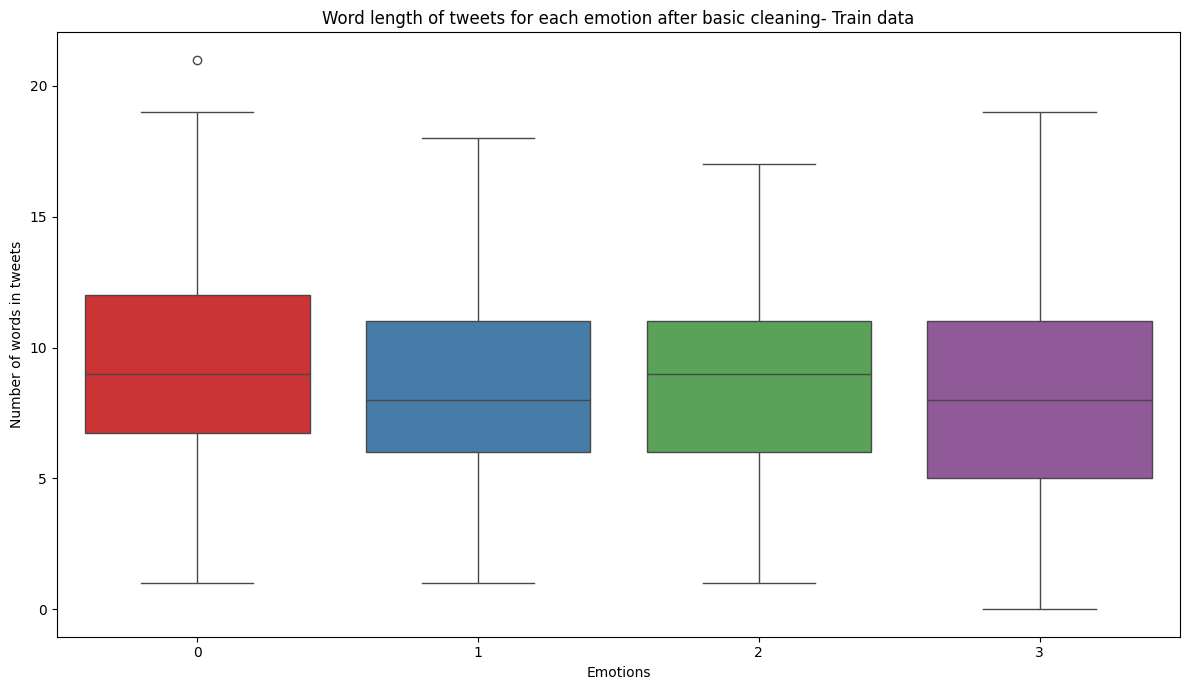

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(data=train_df_cleaned,y="word_len", x="label",palette="Set1")
plt.title("Word length of tweets for each emotion after basic cleaning- Train data")
plt.xlabel("Emotions")
plt.ylabel("Number of words in tweets")
plt.tight_layout()
plt.show()

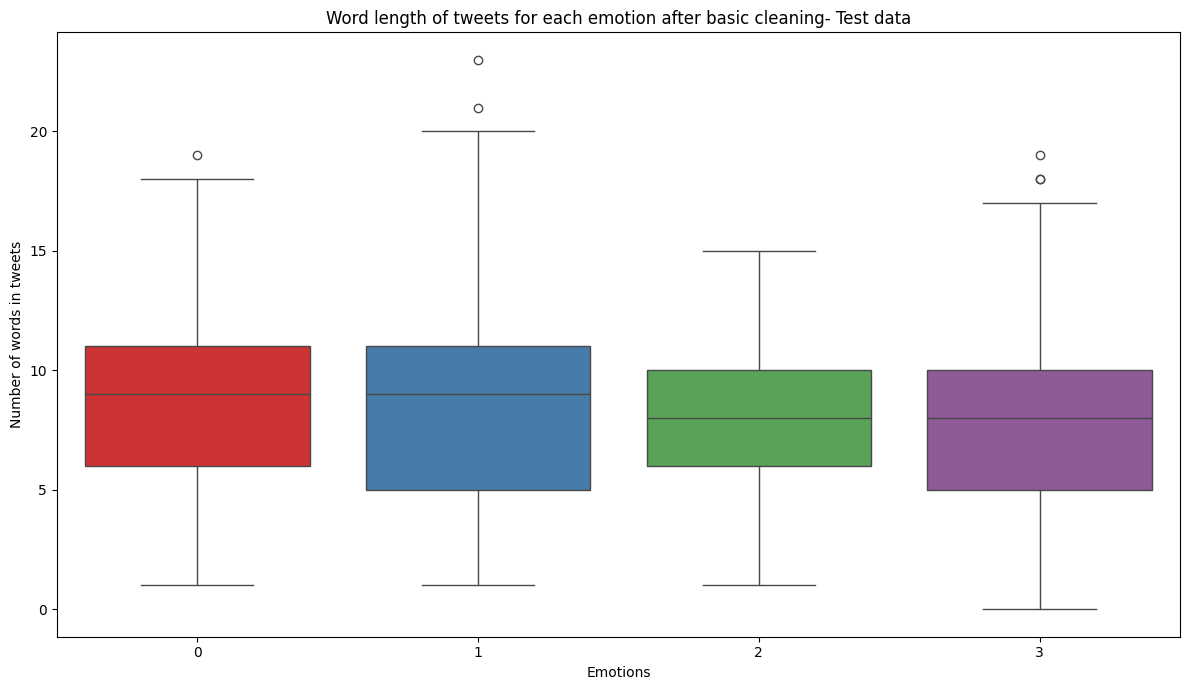

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(data=test_df_cleaned,y="word_len", x="label",palette="Set1")
plt.title("Word length of tweets for each emotion after basic cleaning- Test data")
plt.xlabel("Emotions")
plt.ylabel("Number of words in tweets")
plt.tight_layout()
plt.show()

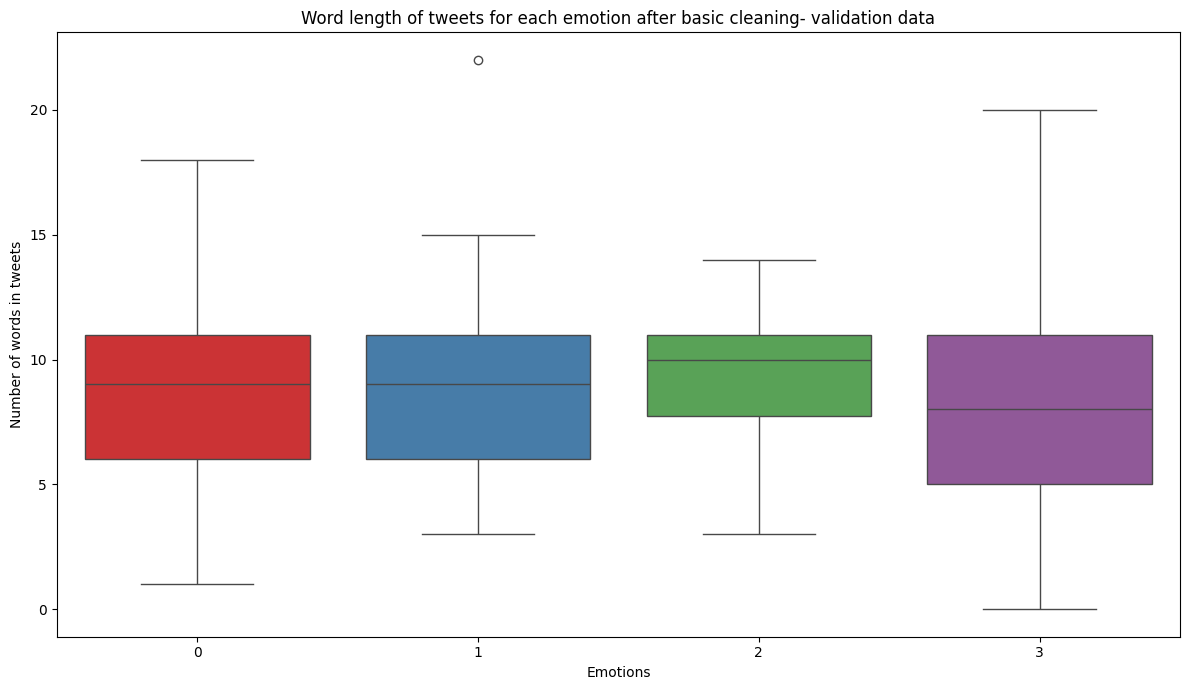

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(data=validation_df_cleaned,y="word_len", x="label",palette="Set1")
plt.title("Word length of tweets for each emotion after basic cleaning- validation data")
plt.xlabel("Emotions")
plt.ylabel("Number of words in tweets")
plt.tight_layout()
plt.show()

####1. Support Vector Classifier (SVC)

In [ ]:
labels_dict = {0:'anger',1: 'joy', 2:'optimism', 3:'sadness'}

In [ ]:
train_df_cleaned['label'] = train_df_cleaned['label'].astype('category')
validation_df_cleaned['label'] = validation_df_cleaned['label'].astype('category')
test_df_cleaned['label'] = test_df_cleaned['label'].astype('category')

tfidf_vectorizer = TfidfVectorizer(max_features=16000)
train_features = tfidf_vectorizer.fit_transform(train_df_cleaned['text'])
val_features = tfidf_vectorizer.transform(validation_df_cleaned['text'])
test_features = tfidf_vectorizer.transform(test_df_cleaned['text'])

svc_model = svm.SVC(kernel='linear')
history_svc = svc_model.fit(train_features, train_df_cleaned['label'])

SVC Model - Test Data
               precision    recall  f1-score   support

           0       0.64      0.89      0.74       558
           1       0.73      0.59      0.65       358
           2       0.61      0.27      0.37       123
           3       0.74      0.60      0.66       382

    accuracy                           0.68      1421
   macro avg       0.68      0.59      0.61      1421
weighted avg       0.69      0.68      0.67      1421

Overall Accuracy for SVC - Test data:  0.6805066854327938
Overall F1 score for SVC - Test data:  0.6670268537983051


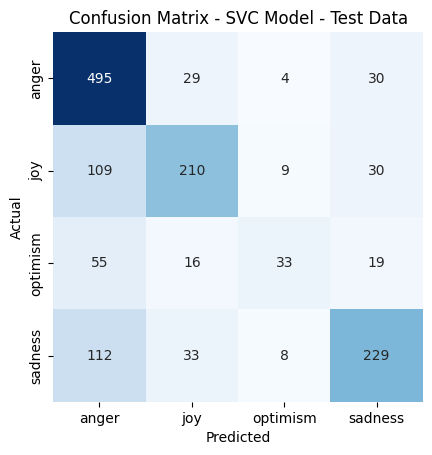

In [ ]:
y_test = test_df_cleaned['label']
y_pred = svc_model.predict(test_features)

report = classification_report(y_test, y_pred, target_names=list(labels_dict.keys()), output_dict=True)
print("SVC Model - Test Data\n", classification_report(y_test, y_pred))
print("Overall Accuracy for SVC - Test data: ", accuracy_score(y_test, y_pred))
print("Overall F1 score for SVC - Test data: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVC Model - Test Data')
plt.show()

####Bidirectional LSTM

####Tokenization

In [ ]:
all_texts = train_df_cleaned['text'].tolist() + test_df_cleaned['text'].tolist() + validation_df_cleaned['text'].tolist()

tokenizer = Tokenizer(num_words=16000)
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
print(f"Total Number of words: {len(word_index)}")

# Function to preprocess data with stemming and tokenization
def preprocess_data(data):
    processed_data = []
    for _, row in data.iterrows():
        sequence = tokenizer.texts_to_sequences([row['text'].split()])[0]
        processed_data.append([sequence, row['label']])
    return processed_data

Total Number of words: 9859


In [ ]:
train_data_processed = preprocess_data(train_df_cleaned)
val_data_processed = preprocess_data(validation_df_cleaned)

In [ ]:
# Separate features and labels, and pad sequences
max_seq_length = max(len(seq[0]) for seq in train_data_processed)
train_X = pad_sequences([row[0] for row in train_data_processed], maxlen=max_seq_length, padding='post')
train_y = np.array([row[1] for row in train_data_processed])
val_X = pad_sequences([row[0] for row in val_data_processed], maxlen=max_seq_length, padding='post')
val_y = np.array([row[1] for row in val_data_processed])

# Convert labels to one-hot encoding
num_classes = 4
train_y_one_hot = to_categorical(train_y, num_classes=num_classes)
val_y_one_hot = to_categorical(val_y, num_classes=num_classes)

print(f"Training set shape: {train_X.shape}, {train_y.shape}")
print(f"Validation set shape: {val_X.shape}, {val_y.shape}")

# Build an bidirectional LSTM model
model = Sequential([
    Embedding(input_dim=16000, output_dim=100, input_length=max_seq_length),
    Bidirectional(LSTM(10, return_sequences=True)),
    Dropout(0.001),
    Bidirectional(LSTM(10)),
    Dropout(0.001),
    Dense(num_classes, activation='relu')])

# Compile the model
optimizer = Adam(learning_rate=0.001)
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy')
model.compile(loss=loss, optimizer=optimizer, metrics=metric)
seed=42
# Train the model
history_bilstm = model.fit(train_X, train_y_one_hot, epochs=10, validation_data=(val_X, val_y_one_hot), verbose=1)

Training set shape: (3257, 21), (3257,)
Validation set shape: (374, 21), (374,)
Epoch 1/10
102/102 [==============================] - 12s 37ms/step - loss: 1.3707 - balanced_accuracy: 0.3162 - val_loss: 1.2880 - val_balanced_accuracy: 0.4973
Epoch 2/10
102/102 [==============================] - 2s 20ms/step - loss: 1.0071 - balanced_accuracy: 0.6076 - val_loss: 1.0482 - val_balanced_accuracy: 0.5936
Epoch 3/10
102/102 [==============================] - 2s 15ms/step - loss: 0.7113 - balanced_accuracy: 0.7485 - val_loss: 0.9517 - val_balanced_accuracy: 0.6203
Epoch 4/10
102/102 [==============================] - 1s 13ms/step - loss: 0.4705 - balanced_accuracy: 0.8545 - val_loss: 0.8992 - val_balanced_accuracy: 0.6738
Epoch 5/10
102/102 [==============================] - 1s 13ms/step - loss: 0.3652 - balanced_accuracy: 0.8741 - val_loss: 0.9253 - val_balanced_accuracy: 0.6551
Epoch 6/10
102/102 [==============================] - 1s 14ms/step - loss: 0.3049 - balanced_accuracy: 0.8839 - va

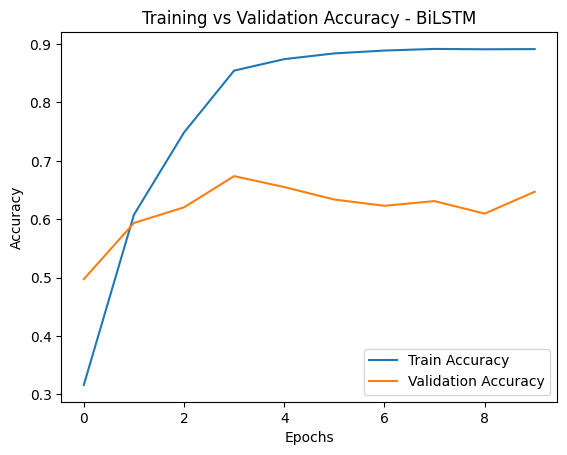

In [ ]:
# Plot training and validation accuracy
plt.plot(history_bilstm.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_bilstm.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

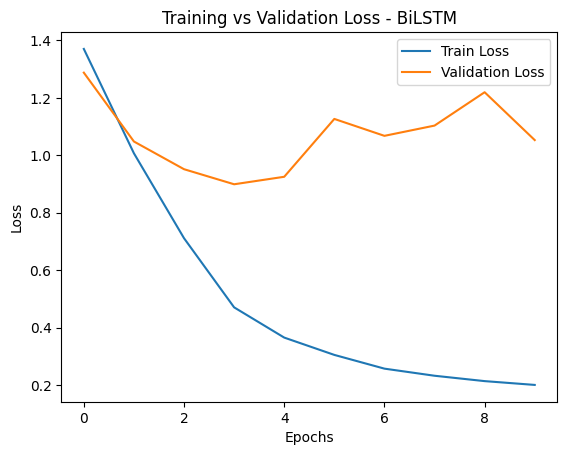

In [ ]:
# Plot training and validation loss
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step

Predicted: sadness, Actual: sadness
1/1 [==============================] - 0s 25ms/step

Predicted: anger, Actual: anger
1/1 [==============================] - 0s 25ms/step

Predicted: anger, Actual: anger
1/1 [==============================] - 0s 26ms/step

Predicted: anger, Actual: anger
1/1 [==============================] - 0s 25ms/step

Predicted: anger, Actual: joy
45/45 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       558
           1       0.60      0.65      0.62       358
           2       0.00      0.00      0.00       123
           3       0.69      0.59      0.64       382

    accuracy                           0.65      1421
   macro avg       0.48      0.52      0.50      1421
weighted avg       0.59      0.65      0.61      1421

Overall Accuracy for BiLSTM - Test data:  0.645320197044335
Overall F1 score for BiLS

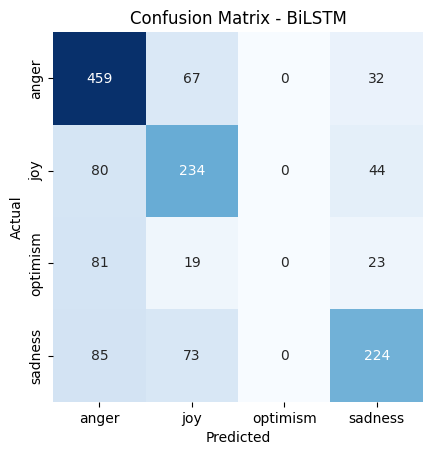

In [ ]:
# Function to predict on sample test data
def predict_text(text):
  sequence = tokenizer.texts_to_sequences([text])[0]
  sequence_padded = pad_sequences([sequence], maxlen=max_seq_length, padding='post')
  prediction = model.predict(sequence_padded)
  return np.argmax(prediction)

# Random predictions for testing
for _ in range(5):
  index = random.randint(0, len(test_df_cleaned) - 1)
  predicted_class = predict_text(test_df_cleaned['text'][index])
  actual_class = test_df_cleaned['label'][index]
  print(f"\nPredicted: {labels_dict[predicted_class]}, Actual: {labels_dict[actual_class]}")

# Evaluate on entire validation set
test_data_processed = preprocess_data(test_df_cleaned)
test_X = pad_sequences([row[0] for row in test_data_processed], maxlen=max_seq_length, padding='post')
test_y = np.array([row[1] for row in test_data_processed])
test_y_one_hot = to_categorical(test_y, num_classes=num_classes)

# Predict classes
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(test_y, y_pred_classes, output_dict=True)
print(classification_report(test_y, y_pred_classes))
print("Overall Accuracy for BiLSTM - Test data: ", report["accuracy"])
print("Overall F1 score for BiLSTM - Test data: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(test_y, y_pred_classes)
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BiLSTM')
plt.show()

####3. BERT Model

In [ ]:
MAX_LEN=64

In [ ]:
#Tokenization
def tokenize(tokenizer, data,max_len=100) :
  input_ids = []
  attention_masks = []
  for i in range(len(data)):
      encoded = tokenizer.encode_plus(
          data[i],
          add_special_tokens=True,
          max_length=max_len,
          padding='max_length',
          return_attention_mask=True
      )
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
def create_model(custom_model, lr_rate, dec, max_len=MAX_LEN):
  ##params###
  opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_rate, decay=dec)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  accuracy = tf.keras.metrics.CategoricalAccuracy('balanced_accuracy')

  input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
  embeddings = custom_model(input_ids,attention_masks)[0]
  out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
  out = tf.keras.layers.Dropout(0.001)(out)
  y = Dense(4,activation = 'relu')(out)
  model = tf.keras.models.Model(inputs=[input_ids,attention_masks], outputs=y)
  model.layers[2].trainable = True
  model.compile(opt, loss=loss, metrics=accuracy)
  return model

In [ ]:
train_df_cleaned['label'] = train_df_cleaned['label'].astype('category')
validation_df_cleaned['label'] = validation_df_cleaned['label'].astype('category')
test_df_cleaned['label'] = test_df_cleaned['label'].astype('category')

In [ ]:
X_train = train_df_cleaned['text'].values
y_train = to_categorical(train_df_cleaned['label'])
X_val = validation_df_cleaned['text'].values
y_val = to_categorical(validation_df_cleaned['label'])
X_test = test_df_cleaned['text'].values
y_test = to_categorical(test_df_cleaned['label'])

In [ ]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
train_input_ids, train_attention_masks = tokenize(bert_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(bert_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(bert_tokenizer, X_test, MAX_LEN)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model = create_model(bert_model, 1e-5, 1e-7, MAX_LEN)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_10[0][0]',            
 el)                         ngAndCrossAttentions(last_   40         'input_11[0][0]']            
                             hidden_state=(None, 64, 76                                           
                             8),                                                            

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=10, batch_size=64)

Epoch 1/10


51/51 [==============================] - 71s 964ms/step - loss: 1.2804 - balanced_accuracy: 0.4240 - val_loss: 1.2062 - val_balanced_accuracy: 0.4572
Epoch 2/10
51/51 [==============================] - 42s 828ms/step - loss: 1.0326 - balanced_accuracy: 0.5720 - val_loss: 0.8954 - val_balanced_accuracy: 0.6658
Epoch 3/10
51/51 [==============================] - 43s 850ms/step - loss: 0.7484 - balanced_accuracy: 0.7178 - val_loss: 0.7254 - val_balanced_accuracy: 0.7353
Epoch 4/10
51/51 [==============================] - 45s 877ms/step - loss: 0.6095 - balanced_accuracy: 0.7673 - val_loss: 0.7080 - val_balanced_accuracy: 0.7567
Epoch 5/10
51/51 [==============================] - 44s 873ms/step - loss: 0.5210 - balanced_accuracy: 0.7998 - val_loss: 0.7040 - val_balanced_accuracy: 0.7406
Epoch 6/10
51/51 [==============================] - 45s 881ms/step - loss: 0.4484 - balanced_accuracy: 0.8176 - val_loss: 0.7423 - val_balanced_accuracy: 0.7460
Epoch 7/10
51/51 [===========================

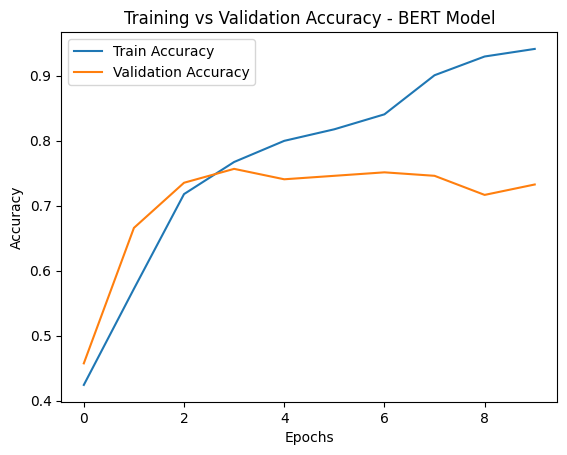

In [ ]:
# Plot training and validation accuracy
plt.plot(history_bert.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_bert.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - BERT Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

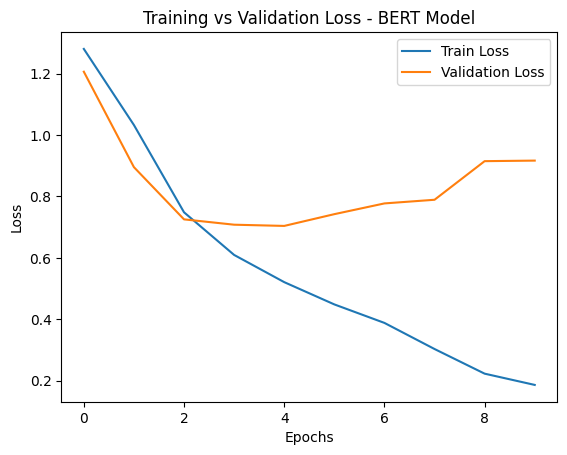

In [ ]:
# Plot training and validation loss
plt.plot(history_bert.history['loss'], label='Train Loss')
plt.plot(history_bert.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - BERT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 7s 162ms/step
BERT Model - Test Data
               precision    recall  f1-score   support

           0       0.83      0.82      0.82       558
           1       0.79      0.75      0.77       358
           2       0.43      0.63      0.51       123
           3       0.75      0.68      0.72       382

   micro avg       0.75      0.75      0.75      1421
   macro avg       0.70      0.72      0.71      1421
weighted avg       0.76      0.75      0.75      1421
 samples avg       0.75      0.75      0.75      1421

Overall Accuracy for BERT - Test data:  0.7494722026741731
Overall F1 score for Test data - BERT Model:  0.7539437495528009


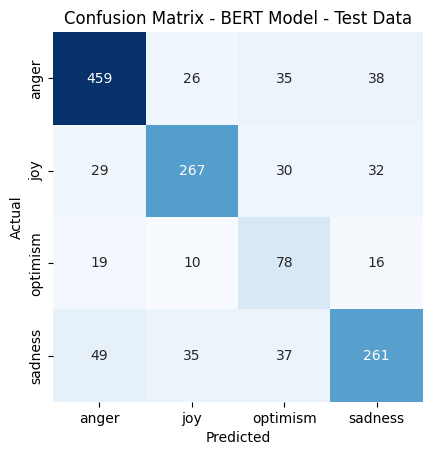

In [ ]:
y_pred = model.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("BERT Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for BERT - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - BERT Model: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT Model - Test Data')
plt.show()

####4. Roberta Model

In [ ]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [ ]:
train_input_ids, train_attention_masks = tokenize(roberta_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(roberta_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(roberta_tokenizer, X_test, MAX_LEN)

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
model_roberta = create_model(roberta_model, 1e-5, 1e-7,MAX_LEN)

In [ ]:
model_roberta.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_roberta_model_2 (TFRobe  TFBaseModelOutputWithPooli   1246456   ['input_14[0][0]',            
 rtaModel)                   ngAndCrossAttentions(last_   32         'input_15[0][0]']            
                             hidden_state=(None, 64, 76                                           
                             8),                                                            

In [ ]:
history_roberta = model_roberta.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=10, batch_size=64)

Epoch 1/10


51/51 [==============================] - 73s 933ms/step - loss: 1.1787 - balanced_accuracy: 0.4817 - val_loss: 1.0125 - val_balanced_accuracy: 0.6070
Epoch 2/10
51/51 [==============================] - 43s 849ms/step - loss: 0.8212 - balanced_accuracy: 0.6997 - val_loss: 0.8080 - val_balanced_accuracy: 0.7139
Epoch 3/10
51/51 [==============================] - 44s 860ms/step - loss: 0.6773 - balanced_accuracy: 0.7504 - val_loss: 0.7336 - val_balanced_accuracy: 0.7273
Epoch 4/10
51/51 [==============================] - 44s 855ms/step - loss: 0.5651 - balanced_accuracy: 0.7974 - val_loss: 0.6863 - val_balanced_accuracy: 0.7299
Epoch 5/10
51/51 [==============================] - 44s 856ms/step - loss: 0.4820 - balanced_accuracy: 0.8222 - val_loss: 0.7039 - val_balanced_accuracy: 0.7273
Epoch 6/10
51/51 [==============================] - 43s 854ms/step - loss: 0.4217 - balanced_accuracy: 0.8483 - val_loss: 0.7275 - val_balanced_accuracy: 0.7166
Epoch 7/10
51/51 [===========================

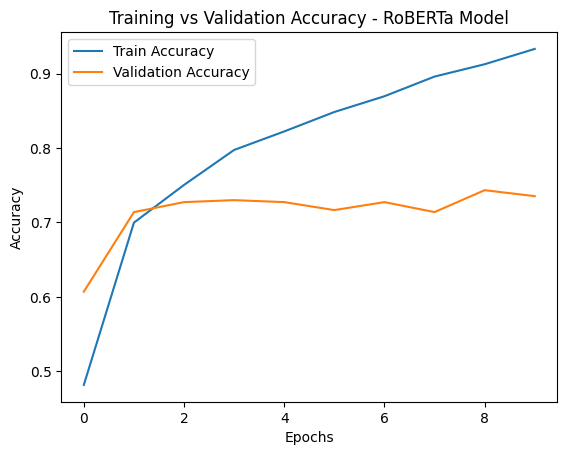

In [ ]:
# Plot training and validation accuracy
plt.plot(history_roberta.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_roberta.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - RoBERTa Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

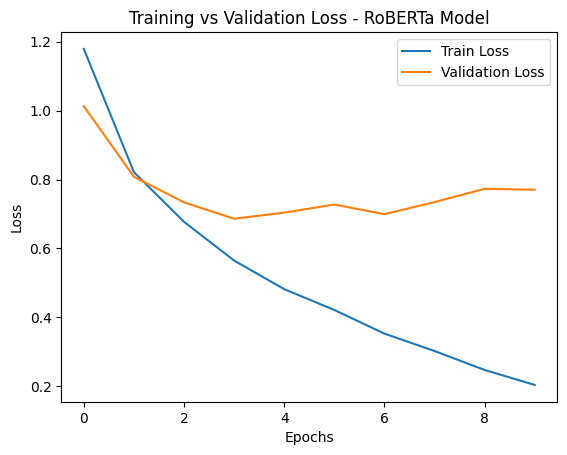

In [ ]:
# Plot training and validation loss
plt.plot(history_roberta.history['loss'], label='Train Loss')
plt.plot(history_roberta.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - RoBERTa Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 11s 134ms/step
RoBERTa Model - Test Data
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       558
           1       0.78      0.78      0.78       358
           2       0.60      0.54      0.57       123
           3       0.73      0.79      0.76       382

   micro avg       0.78      0.78      0.78      1421
   macro avg       0.74      0.73      0.74      1421
weighted avg       0.78      0.78      0.78      1421
 samples avg       0.78      0.78      0.78      1421

Overall Accuracy for RoBERTa - Test data:  0.776917663617171
Overall F1 score for Test data - RoBERTa Model:  0.7766221497444199


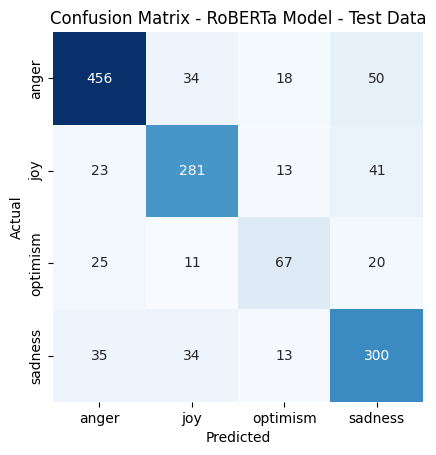

In [ ]:
y_pred = model_roberta.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("RoBERTa Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for RoBERTa - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - RoBERTa Model: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RoBERTa Model - Test Data')
plt.show()

####5. DistilBert Model

In [ ]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [ ]:
train_input_ids, train_attention_masks = tokenize(distilbert_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(distilbert_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(distilbert_tokenizer, X_test, MAX_LEN)

In [ ]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model_distilbert = create_model(distilbert_model, 1e-5, 1e-7, MAX_LEN)

In [ ]:
model_distilbert.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_1 (TF  TFBaseModelOutput(last_hid   6636288   ['input_18[0][0]',            
 DistilBertModel)            den_state=(None, 64, 768),   0          'input_19[0][0]']            
                              hidden_states=None, atten                                           
                             tions=None)                                                    

In [ ]:
history_distilbert = model_distilbert.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=10, batch_size=64)

Epoch 1/10
51/51 [==============================] - 35s 462ms/step - loss: 1.2161 - balanced_accuracy: 0.4725 - val_loss: 1.1132 - val_balanced_accuracy: 0.5348
Epoch 2/10
51/51 [==============================] - 23s 443ms/step - loss: 0.9063 - balanced_accuracy: 0.6567 - val_loss: 0.8581 - val_balanced_accuracy: 0.6845
Epoch 3/10
51/51 [==============================] - 22s 431ms/step - loss: 0.6983 - balanced_accuracy: 0.7369 - val_loss: 0.7679 - val_balanced_accuracy: 0.7139
Epoch 4/10
51/51 [==============================] - 22s 426ms/step - loss: 0.5978 - balanced_accuracy: 0.7703 - val_loss: 0.7727 - val_balanced_accuracy: 0.6872
Epoch 5/10
51/51 [==============================] - 22s 428ms/step - loss: 0.5209 - balanced_accuracy: 0.8014 - val_loss: 0.7698 - val_balanced_accuracy: 0.7166
Epoch 6/10
51/51 [==============================] - 22s 425ms/step - loss: 0.4271 - balanced_accuracy: 0.8554 - val_loss: 0.8078 - val_balanced_accuracy: 0.7005
Epoch 7/10
51/51 [================

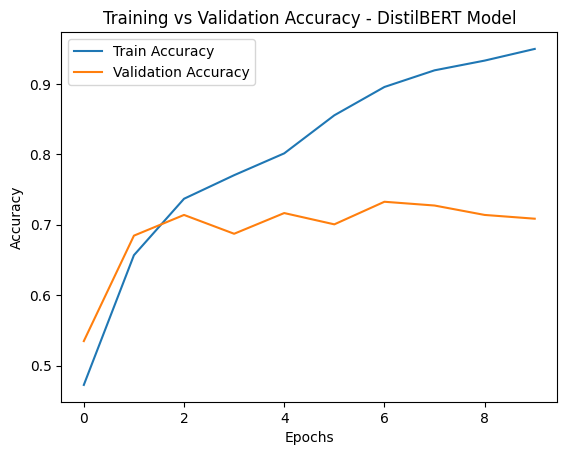

In [ ]:
# Plot training and validation accuracy
plt.plot(history_distilbert.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_distilbert.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - DistilBERT Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

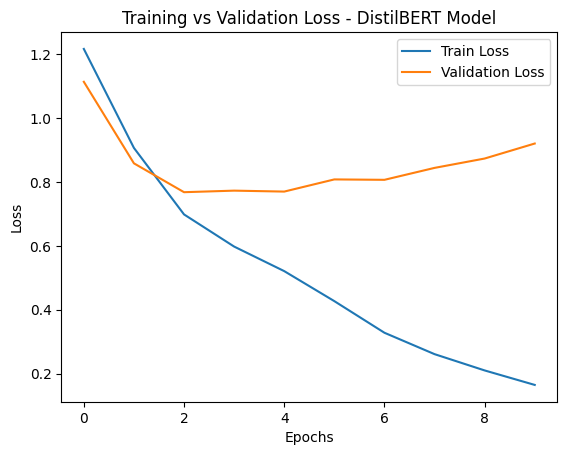

In [ ]:
# Plot training and validation loss
plt.plot(history_distilbert.history['loss'], label='Train Loss')
plt.plot(history_distilbert.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - DistilBERT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 5s 76ms/step
DistilBERT Model - Test Data
               precision    recall  f1-score   support

           0       0.84      0.79      0.82       558
           1       0.75      0.80      0.78       358
           2       0.54      0.49      0.51       123
           3       0.72      0.76      0.74       382

   micro avg       0.76      0.76      0.76      1421
   macro avg       0.71      0.71      0.71      1421
weighted avg       0.76      0.76      0.76      1421
 samples avg       0.76      0.76      0.76      1421

Overall Accuracy for DistilBERT - Test data:  0.7593244194229416
Overall F1 score for Test data - DistilBERT Model:  0.7590735921212601


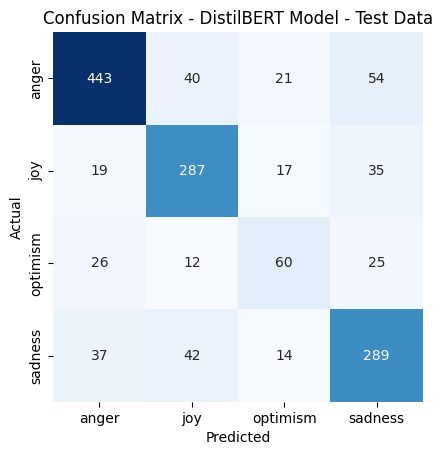

In [ ]:
y_pred = model_distilbert.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("DistilBERT Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for DistilBERT - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - DistilBERT Model: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DistilBERT Model - Test Data')
plt.show()

####Fine tuning

####DistilBERT model

In [ ]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_input_ids, train_attention_masks = tokenize(distilbert_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(distilbert_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(distilbert_tokenizer, X_test, MAX_LEN)

In [ ]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model_distilbert = create_model(distilbert_model, 1e-5, 1e-8, MAX_LEN)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model_distilbert.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_33 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_7 (TF  TFBaseModelOutput(last_hid   6636288   ['input_32[0][0]',            
 DistilBertModel)            den_state=(None, 64, 768),   0          'input_33[0][0]']            
                              hidden_states=None, atten                                           
                             tions=None)                                                   

In [ ]:
history_distilbert = model_distilbert.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=12, batch_size=64)

Epoch 1/12
88/88 [==============================] - 49s 439ms/step - loss: 1.2779 - balanced_accuracy: 0.3688 - val_loss: 1.0043 - val_balanced_accuracy: 0.5989
Epoch 2/12
88/88 [==============================] - 37s 415ms/step - loss: 0.9077 - balanced_accuracy: 0.6037 - val_loss: 0.8549 - val_balanced_accuracy: 0.6711
Epoch 3/12
88/88 [==============================] - 37s 419ms/step - loss: 0.5005 - balanced_accuracy: 0.8245 - val_loss: 0.8388 - val_balanced_accuracy: 0.6818
Epoch 4/12
88/88 [==============================] - 37s 418ms/step - loss: 0.3055 - balanced_accuracy: 0.8943 - val_loss: 0.8631 - val_balanced_accuracy: 0.7219
Epoch 5/12
88/88 [==============================] - 36s 412ms/step - loss: 0.1963 - balanced_accuracy: 0.9405 - val_loss: 0.9529 - val_balanced_accuracy: 0.7166
Epoch 6/12
88/88 [==============================] - 36s 414ms/step - loss: 0.1431 - balanced_accuracy: 0.9541 - val_loss: 1.0200 - val_balanced_accuracy: 0.6872
Epoch 7/12
88/88 [================

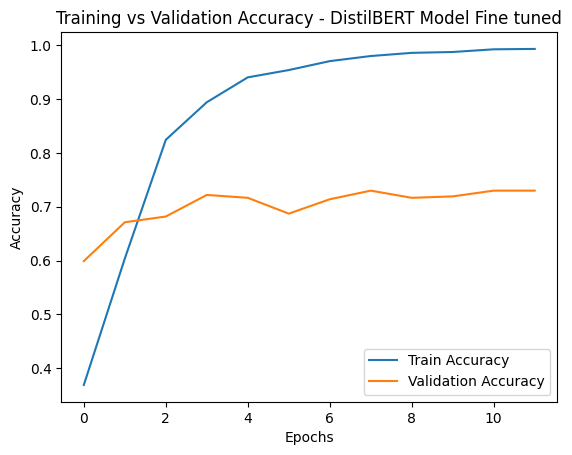

In [ ]:
# Plot training and validation accuracy
plt.plot(history_distilbert.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_distilbert.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - DistilBERT Model Fine tuned')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

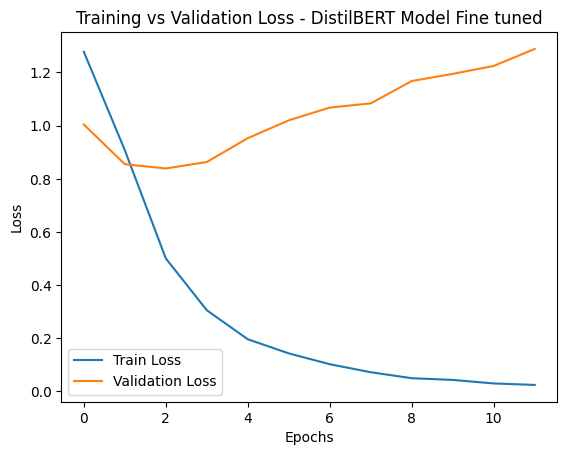

In [ ]:
# Plot training and validation loss
plt.plot(history_distilbert.history['loss'], label='Train Loss')
plt.plot(history_distilbert.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - DistilBERT Model Fine tuned')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 5s 78ms/step
DistilBERT Model - Test Data
               precision    recall  f1-score   support

           0       0.80      0.85      0.82       558
           1       0.78      0.75      0.77       358
           2       0.56      0.48      0.52       123
           3       0.73      0.73      0.73       382

   micro avg       0.76      0.76      0.76      1421
   macro avg       0.72      0.70      0.71      1421
weighted avg       0.76      0.76      0.76      1421
 samples avg       0.76      0.76      0.76      1421

Overall Accuracy for DistilBERT - Test data:  0.7600281491907108
Overall F1 score for Test data - DistilBERT Model Fine tuned:  0.7578169184601762


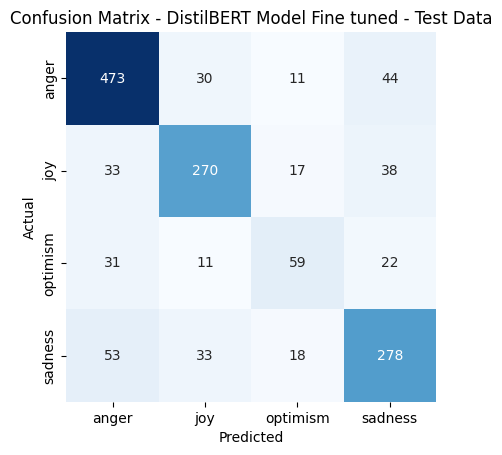

In [ ]:
y_pred = model_distilbert.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("DistilBERT Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for DistilBERT - Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for Test data - DistilBERT Model Fine tuned: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DistilBERT Model Fine tuned - Test Data')
plt.show()

####Oversampling
To overcome the possible negative effects of class imbalance in the training data, the approach of random oversampling has been used to examine the difference in the model performance. Here, only DistilBERT has been checked for oversampled train data.

**Oversampling is the technique used to treat the class imbalance in training samples by adding more data samples to the minority class to match the level of majority class**. Here the train data contains the highest records of 1400 for the emotion label - anger. Hence after oversampling the overall training data samples will be increased to 5600 (1400 x 4) with each class containing the same number of data records for training.

However, with the DistilBERT model examined, it could be seen that there is not much of a difference in the model performance before and after treating the class imbalance with oversampling technique.


In [ ]:
train_x, train_y = RandomOverSampler().fit_resample(np.array(train_df_cleaned['text']).reshape(-1, 1), np.array(train_df_cleaned['label']).reshape(-1, 1))
train_os_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'label'])

In [ ]:
X_train = train_os_df['text'].values
y_train = to_categorical(train_os_df['label'])
X_val = validation_df_cleaned['text'].values
y_val = to_categorical(validation_df_cleaned['label'])
X_test = test_df_cleaned['text'].values
y_test = to_categorical(test_df_cleaned['label'])

In [ ]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [ ]:
train_input_ids, train_attention_masks = tokenize(distilbert_tokenizer, X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(distilbert_tokenizer, X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(distilbert_tokenizer, X_test, MAX_LEN)

In [ ]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model_distilbert = create_model(distilbert_model, 1e-5, 1e-7, MAX_LEN)

In [ ]:
model_distilbert.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 input_29 (InputLayer)       [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model_5 (TF  TFBaseModelOutput(last_hid   6636288   ['input_28[0][0]',            
 DistilBertModel)            den_state=(None, 64, 768),   0          'input_29[0][0]']            
                              hidden_states=None, atten                                           
                             tions=None)                                                   

In [ ]:
history_distilbert = model_distilbert.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=10, batch_size=64)

Epoch 1/10
88/88 [==============================] - 48s 443ms/step - loss: 1.2153 - balanced_accuracy: 0.4516 - val_loss: 0.9602 - val_balanced_accuracy: 0.6150
Epoch 2/10
88/88 [==============================] - 37s 415ms/step - loss: 0.6942 - balanced_accuracy: 0.7371 - val_loss: 0.7577 - val_balanced_accuracy: 0.7166
Epoch 3/10
88/88 [==============================] - 37s 420ms/step - loss: 0.4168 - balanced_accuracy: 0.8532 - val_loss: 0.8197 - val_balanced_accuracy: 0.7139
Epoch 4/10
88/88 [==============================] - 37s 418ms/step - loss: 0.2633 - balanced_accuracy: 0.9159 - val_loss: 0.8515 - val_balanced_accuracy: 0.7219
Epoch 5/10
88/88 [==============================] - 37s 419ms/step - loss: 0.1730 - balanced_accuracy: 0.9441 - val_loss: 0.9873 - val_balanced_accuracy: 0.7166
Epoch 6/10
88/88 [==============================] - 37s 418ms/step - loss: 0.1226 - balanced_accuracy: 0.9602 - val_loss: 1.0381 - val_balanced_accuracy: 0.7246
Epoch 7/10
88/88 [================

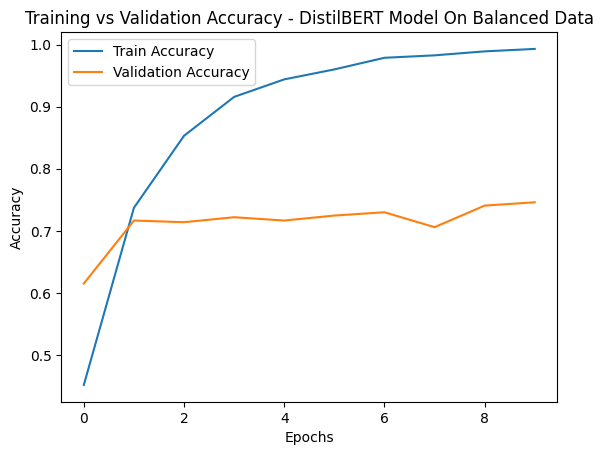

In [ ]:
# Plot training and validation accuracy
plt.plot(history_distilbert.history['balanced_accuracy'], label='Train Accuracy')
plt.plot(history_distilbert.history['val_balanced_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - DistilBERT Model On Balanced Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

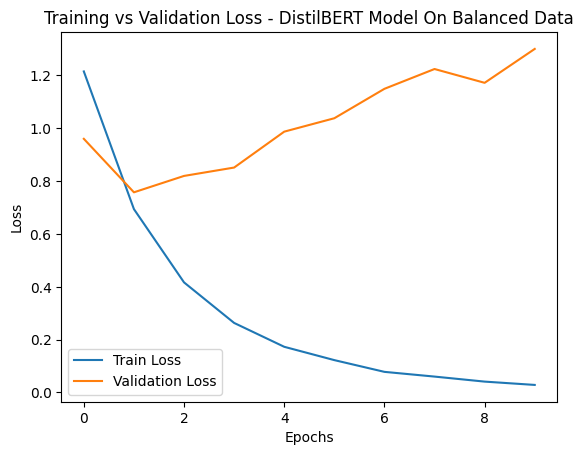

In [ ]:
# Plot training and validation loss
plt.plot(history_distilbert.history['loss'], label='Train Loss')
plt.plot(history_distilbert.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss - DistilBERT Model On Balanced Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

45/45 [==============================] - 4s 78ms/step
DistilBERT Model - Test Data
               precision    recall  f1-score   support

           0       0.77      0.86      0.81       558
           1       0.79      0.78      0.78       358
           2       0.51      0.50      0.51       123
           3       0.79      0.67      0.73       382

   micro avg       0.76      0.76      0.76      1421
   macro avg       0.71      0.70      0.71      1421
weighted avg       0.76      0.76      0.76      1421
 samples avg       0.76      0.76      0.76      1421

Overall Accuracy for DistilBERT (Balanced Train Data)- Test data:  0.757213230119634
Overall F1 score for DistilBERT Model (Balanced Train Data)- Test data:  0.7553302435499106


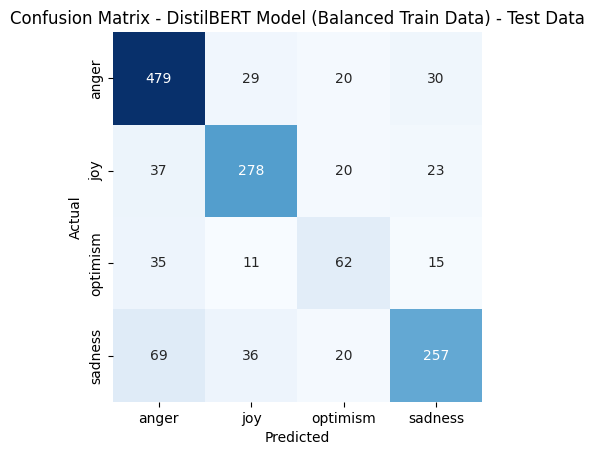

In [ ]:
y_pred = model_distilbert.predict([test_input_ids,test_attention_masks])
y_pred_classes =  np.zeros_like(y_pred)
y_pred_classes[np.arange(len(y_pred_classes)), y_pred.argmax(1)] = 1

report = classification_report(y_test, y_pred_classes, target_names=list(labels_dict.keys()), output_dict=True)
print("DistilBERT Model - Test Data\n", classification_report(y_test, y_pred_classes))
print("Overall Accuracy for DistilBERT (Balanced Train Data)- Test data: ", accuracy_score(y_test, y_pred_classes))
print("Overall F1 score for DistilBERT Model (Balanced Train Data)- Test data: ", report["weighted avg"]["f1-score"])

# Confusion matrix
cm = confusion_matrix(y_test.argmax(1),y_pred_classes.argmax(1))
df_cm = pd.DataFrame(cm, index=labels_dict.values(), columns=labels_dict.values())
ax = sns.heatmap(df_cm, annot=True, fmt='d', square=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - DistilBERT Model (Balanced Train Data) - Test Data')
plt.show()

###Observations and Conclusions:
On analysing the given dataset, it could be seen that:
1. Maximum word length of tweets before text cleaning process was\
    -- 33 in train data samples\
    -- 36 in test data samples\
    -- 32 in validation data samples
2. And after the eight step text cleaning including:\
    -- Changing to lower case\
    -- Exapnding words like you're to you are, i'm to I am\
    -- Removing emails\
    -- Removing html tags\
    -- Removing special characters like @, #, % etc\
    -- Removing accented characters like u^, `a etc\
    -- Lemmatization - changing to root word form\
    -- Removal of stop words such as a, the etc\
  The maximum word length of tweets were:\
    -- 21 in train data samples\
    -- 23 in test data samples\
    -- 22 in validation data samples

This shows that in the given tweets datasets **one third of the data/word is lost with text cleaning particularly due to stop words removal**. The impact of this loss of information could be seen from the **performance results of the five models which is in overall less than those implemented without removing stop words**. Refer to file nlp_a3_final_implementation.ipynb.

This exploration made an important observation that **not all text based datasets require all the text cleaning steps**. Any Preprocessing technique adapted would be beneficial only if it is appropriate/required for a given dataset. So the **nature of the dataset lays a key role in determining the choice of techniques to be used**. Here, since the individual tweet length is only around 30-40 words, removal of stop words caused a reasonable loss of data for the models to learn the pattern. May be in case of processing volumous textual documents, it would be beneficial to remove stop words where it could act as noise not contributing much towards adding any meaning or context. But here it is not the case.

Hence, the final implementation (file_name: nlp_a3_final_implementation.ipynb) involves only the below text cleaning steps:\
    -- Changing to lower case\
    -- Exapnding words like you're to you are, i'm to I am\
    -- Removing emails\
    -- Removing html tags\
    -- Removing special characters like @, #, % etc\
    -- Removing accented characters like u^, `a etc

